# Autocodificadores

<table align='left'>
<tr><td> <img src="../figures/autoencoder_schema.jpg"> </td></tr>
</table>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import numpy as np
from collections import OrderedDict

from PIL import Image
from IPython import display

import torch
from torch.autograd import Variable
from torch import nn
from torch.optim import lr_scheduler
import torchvision

import lib.pytorch_trainer as ptt

use_gpu = torch.cuda.is_available()
print('GPU available:', use_gpu)

GPU available: True


## Carregamento do MNIST dataset (já está no disco)

A base de dados MNIST está disponível em: http://yann.lecun.com/exdb/mnist/
Consiste de 60 mil amostras de treinamento e 10 mil amostras de teste. Cada amostra é uma pequena imagem em níveis de cinza de tamanho 28x28 pixels com valores entre 0 e 255.

A base já está carregada e disponível em /data/datasets:

In [2]:
x_train, y_train = torch.load('/data/datasets/MNIST/processed/training.pt')
x_test,  y_test  = torch.load('/data/datasets/MNIST/processed/test.pt')

In [3]:
print(x_train.shape, x_test.shape)

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])


## Treinando com pouquíssimos dados

In [4]:
if False:
    n_train_samples = 1000
    n_test_samples = 500
else:
    n_train_samples = x_train.shape[0]
    n_test_samples  = x_test.shape[0]
xx_train = x_train[:n_train_samples].float() /255.
yy_train = y_train[:n_train_samples] 
xx_test  = x_test[:n_test_samples].float() / 255.
yy_test  = y_test[:n_test_samples]

In [5]:
xx_train.shape, xx_test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [6]:
xx_train.type(),yy_train.type(), xx_test.type(), yy_test.type()

('torch.FloatTensor',
 'torch.LongTensor',
 'torch.FloatTensor',
 'torch.LongTensor')

## Cria a rede

<table align='left'>
<tr><td> <img src="../figures/autoencoder_1.png",width=600pt> </td></tr>
</table>

In [7]:
class MyAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.dense1 = nn.Linear(28*28, 512)
        self.relu1 = nn.ReLU()
        self.dense2 = nn.Linear(512, 128)
        self.relu2 = nn.ReLU()
        self.dense3 = nn.Linear(128, 2)
        self.dense4 = nn.Linear(2, 128)
        self.relu3 = nn.ReLU()
        self.dense5 = nn.Linear(128, 512)
        self.relu4 = nn.ReLU()
        self.dense6 = nn.Linear(512, 28*28)
    def encode(self, x):
        x = x.view(-1, 28*28)
        x = self.dense1(x)
        x = self.relu1(x)
        x = self.dense2(x)
        x = self.relu2(x)
        x = self.dense3(x)
        return x
    def decode(self, x):
        x = self.dense4(x)
        x = self.relu3(x)
        x = self.dense5(x)
        x = self.relu4(x)
        x = self.dense6(x)
        x = x.view(-1, 28, 28)
        return x
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

In [8]:
model = MyAutoEncoder()
print(model)

MyAutoEncoder (
  (dense1): Linear (784 -> 512)
  (relu1): ReLU ()
  (dense2): Linear (512 -> 128)
  (relu2): ReLU ()
  (dense3): Linear (128 -> 2)
  (dense4): Linear (2 -> 128)
  (relu3): ReLU ()
  (dense5): Linear (128 -> 512)
  (relu4): ReLU ()
  (dense6): Linear (512 -> 784)
)


## Cria o trainer

In [9]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=0)
savebest = ptt.ModelCheckpoint('../../models/auto_encoder_pt',reset=True, verbose=1)
trainer = ptt.DeepNetTrainer( 
                         model, 
                         criterion, 
                         optimizer=optimizer,
                         lr_scheduler=lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1),
                         callbacks = [savebest, ptt.PrintCallback()]
                        )

## Treinamento

In [10]:
retrain = True
if retrain:
    trainer.fit(n_epochs=20, Xin=xx_train, Yin=xx_train,
                valid_data=(xx_test, xx_test), batch_size=20)
else:
    trainer.load_state('/data/models/auto_encoder_pt')

Start training for 20 epochs
  1:   6.8s   T: 0.04631   V: 0.04267 best
  2:   6.1s   T: 0.04110   V: 0.04004 best
  3:   6.1s   T: 0.03994   V: 0.03928 best
  4:   6.1s   T: 0.03876   V: 0.03843 best
  5:   6.0s   T: 0.03825   V: 0.03816 best
  6:   6.0s   T: 0.03796   V: 0.03767 best
  7:   6.0s   T: 0.03635   V: 0.03631 best
  8:   6.1s   T: 0.03594   V: 0.03615 best
  9:   6.1s   T: 0.03576   V: 0.03605 best
 10:   6.1s   T: 0.03559   V: 0.03594 best
 11:   6.1s   T: 0.03547   V: 0.03591 best
 12:   6.1s   T: 0.03533   V: 0.03581 best
 13:   6.1s   T: 0.03521   V: 0.03574 best
 14:   6.1s   T: 0.03502   V: 0.03566 best
 15:   6.0s   T: 0.03495   V: 0.03566 best
 16:   6.0s   T: 0.03492   V: 0.03566 
 17:   6.0s   T: 0.03490   V: 0.03564 best
 18:   6.0s   T: 0.03487   V: 0.03564 best
 19:   6.0s   T: 0.03485   V: 0.03564 
 20:   6.1s   T: 0.03484   V: 0.03563 best
Best model was saved at epoch 20 with loss 0.03563: ../../models/auto_encoder_pt
Stop training at epoch: 20/20


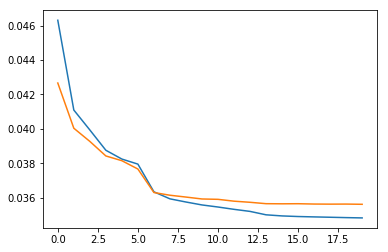

In [11]:
tra_loss = trainer.metrics['train']['losses']
val_loss = trainer.metrics['valid']['losses']
epochs = np.arange(len(tra_loss))
plt.plot(epochs, tra_loss, epochs, val_loss)

In [12]:
yy_pred = trainer.predict(xx_test)

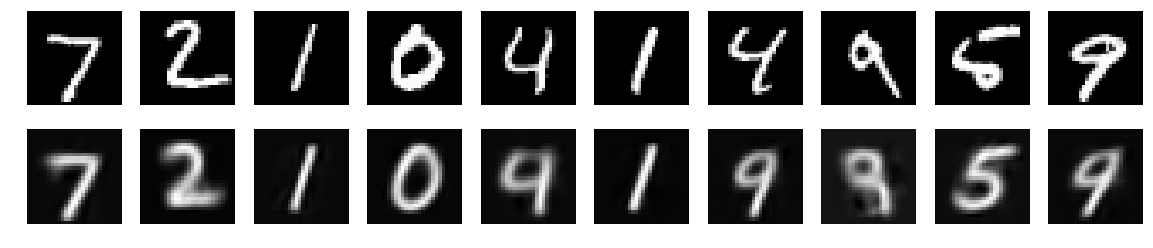

In [13]:
n = 10
plt.figure(figsize=(20, 4))
plt.gray()
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(xx_test[i].numpy().reshape(28, 28))
    plt.axis('off')

    # display reconstruction
    ax = plt.subplot(2, n, i+1 + n)
    plt.imshow(yy_pred[i].cpu().numpy().reshape(28, 28))
    plt.axis('off')
plt.show()

## Imagens no plano 2D

In [15]:
xin = Variable(xx_train.view(-1, 28*28))
if use_gpu:
    xin = xin.cuda()
encoded = trainer.model.encode(xin)
encoded_data = encoded.data.cpu().numpy()

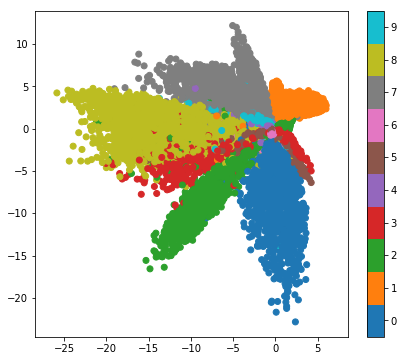

In [16]:
plt.figure(figsize=(7, 6))
plt.scatter(encoded_data[:, 0], encoded_data[:, 1], c=yy_train.numpy(), cmap=plt.cm.tab10, vmin=-.5, vmax=9.5)
plt.axis('equal')
cbar = plt.colorbar();
cbar.set_ticks(np.arange(10))
plt.show()

## transformação na imagem ao percorrer uma linha reta no espaço 2D

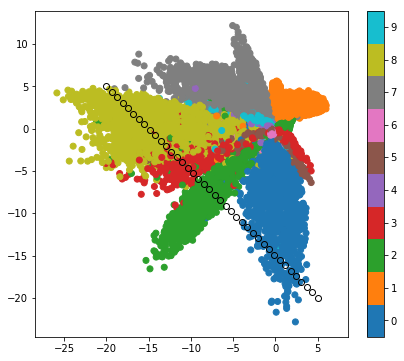

In [20]:
n = 40
x = np.linspace(-20.,   5., n)
y = np.linspace(  5., -20., n)
plt.figure(figsize=(7, 6))
plt.scatter(encoded_data[:, 0], encoded_data[:, 1], c=yy_train.numpy(), cmap=plt.cm.tab10, vmin=-.5, vmax=9.5)
plt.plot(x, y, 'ko', mfc='none')
plt.axis('equal')
cbar = plt.colorbar();
cbar.set_ticks(np.arange(10))
plt.show()

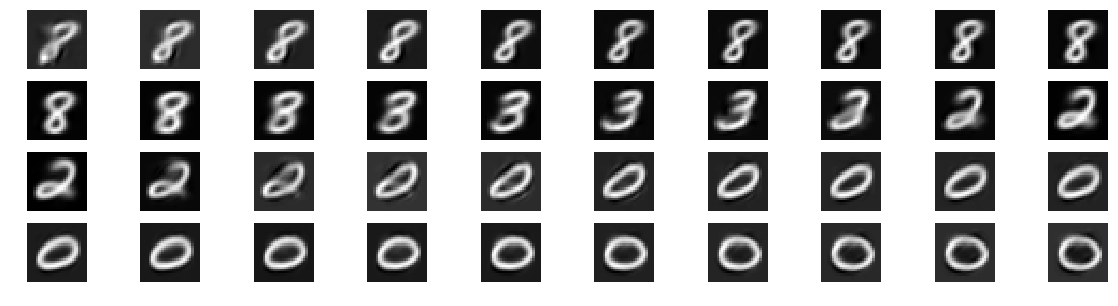

In [21]:
data = np.array([x, y]).T
data = torch.from_numpy(data).type(torch.FloatTensor)

data_in = Variable(data)
if use_gpu:
    data_in = data_in.cuda()
    
out = trainer.model.decode(data_in)
out = out.view(-1, 28, 28)
                    
plt.figure(figsize=(20, 5))
plt.gray()

for i in range(n):
    ax = plt.subplot(4, n//4, i+1)
    plt.imshow(out[i].data.cpu().numpy().reshape(28, 28))
    plt.axis('off')
plt.show()

## transformação na imagem ao percorrer um círculo no espaço 2D

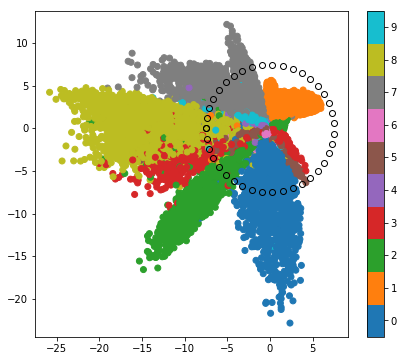

In [22]:
n = 40
phi = np.linspace(-np.pi, np.pi, n)
r = 7.5
x = r * np.cos(phi)
y = r * np.sin(phi)
plt.figure(figsize=(7, 6))
plt.scatter(encoded_data[:, 0], encoded_data[:, 1], c=yy_train.numpy(), cmap=plt.cm.tab10, vmin=-.5, vmax=9.5)
plt.plot(x, y, 'ko', mfc='none')
plt.axis('equal')
cbar = plt.colorbar();
cbar.set_ticks(np.arange(10))
plt.show()

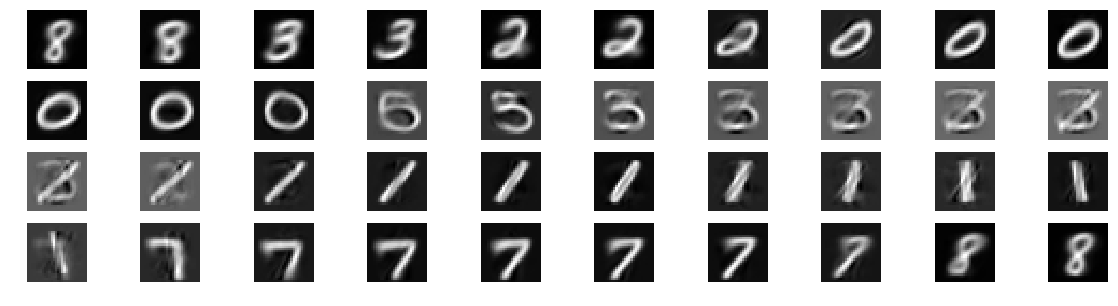

In [24]:
data = np.array([x, y]).T
data = torch.from_numpy(data).type(torch.FloatTensor)

data_in = Variable(data)
if use_gpu:
    data_in = data_in.cuda()
    
out = trainer.model.decode(data_in)
out = out.view(-1, 28, 28)
                    
plt.figure(figsize=(20, 5))
plt.gray()

for i in range(n):
    ax = plt.subplot(4, n//4, i+1)
    plt.imshow(out[i].data.cpu().numpy().reshape(28, 28))
    plt.axis('off')
plt.show()

# Atividades
## Exercícios
1. Escolha um código (duas coordenadas no espaço 2D mostrado acima), e utilize o decoder (model.decoder) para mostrar qual é a saída correspondente da rede treinada.
2. Aplique o encoder (model.encoder) da rede treinada para obter quais os códigos correspondentes a cada imagem de entrada; encontre uma maneira de filtrar os códigos para descobrir qual a imagem e classificação do outlier na imagem do espaço 2D mostrado acima.